In [3]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

from innlib.models import DeepConditionalModel
from innlib.training import train_online
from innlib.losses import maximum_likelihood_loss
from innlib.viz import plot_true_est_scatter, plot_true_est_posterior
import innlib.diagnostics as diag

In [4]:
tf.enable_eager_execution()

In [5]:
%load_ext autoreload
%autoreload 2

# Summary network definition 
<p> The summary network is responsible to learn a fixed size representation of the observed data and extract
    maximally informative statistics from the data. </p>

In [6]:
class SummaryNetwork(tf.keras.Model):
    def __init__(self, meta):
        super(SummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|theta)
        """
        
        pass

# Forward model priors and generator

In [32]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Just as a toy example, sample from 4-D unit Gaussian
    theta = np.random.randn(batch_size, 4)
    return theta

In [27]:
def forward_model(params, n_obs, **args):
    """
    Runs the forward model ones, i.e., generates a sample from p(x|theta).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = np.random.normal(loc=params, size=(n_obs, params.shape[0]))
    return x

In [42]:
def data_generator(batch_size, n_obs=128, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : int -- the numebr of observations to draw from p(x|theta)
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = np.apply_along_axis(forward_model, axis=1, arr=theta, n_obs=n_obs, **args)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return theta, x

# Training hyperparameters

In [72]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5
                
summary_meta = None


# Forward model hyperparameters
param_names = ['dummy1', 'dummy2', 'dummy3']
theta_dim = len(param_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "wcst_test"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create test data

In [45]:
%%time
theta_test, x_test = data_generator(n_test)

Wall time: 22 ms


## Create networks

In [79]:
summary_net = lambda x, training=True : tf.reduce_mean(x, axis=1)  # Dummy
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

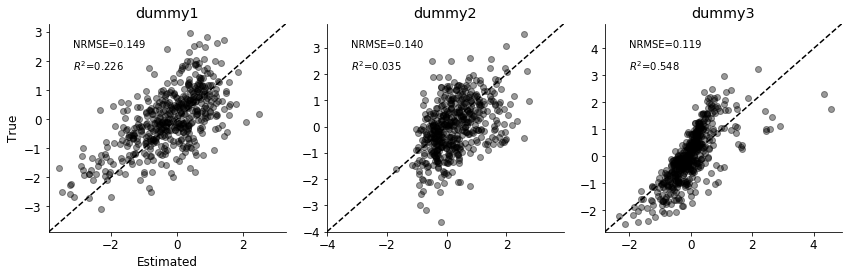

In [80]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

## Manage checkpoints

In [81]:
# checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
# manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)
# if manager.latest_checkpoint:
#     print("Restored from {}".format(manager.latest_checkpoint))
# else:
#     print("Initializing from scratch.")

# Train networks

In [83]:
# %%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_generator, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              global_step=global_step)

#         # Store checkpoint
#         manager.save()

# Test performance

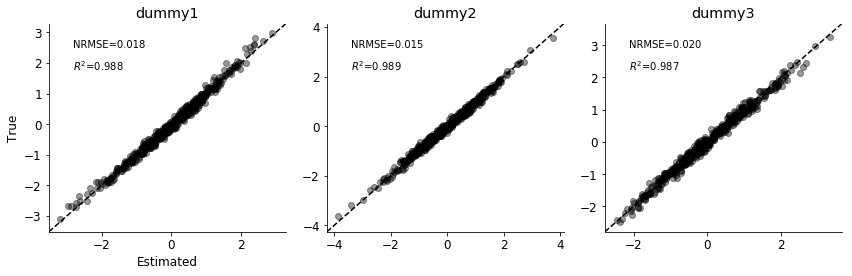

In [84]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))